# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [43]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### 데이터 셋 읽어오기

In [44]:
import pandas as pd
from textblob import TextBlob
from tqdm.auto import tqdm  # tqdm의 Jupyter 노트북에 최적화된 버전을 사용합니다.

tqdm.pandas()  # pandas 연산에 대한 tqdm의 진행 표시줄 활성화

# 오타 수정 함수를 TextBlob을 사용하도록 변경
def correct_typos_with_textblob(string):
    if pd.isnull(string):
        return string
    corrected_text = TextBlob(string.lower()).correct() #대문자를 다 소문자로 고친후 코드 돌림
    return str(corrected_text)

# Load the CSV files
df_train = pd.read_csv("train.csv")  # 학습용 데이터
df_test = pd.read_csv("submission.csv")  # 테스트 데이터(제출 파일의 데이터)
#df_train.fillna("", inplace=True)  # 결측치를 빈 문자열로 대체
#df_test.fillna("", inplace=True)  # 결측치를 빈 문자열로 대체

# '/'로 나누어진 데이터의 마지막 요소 추출 함수는 그대로 유지
def extract_last_country(value):
    return value.split('/')[-1] if pd.notnull(value) else value

# Apply the function to 'customer_country' and 'customer_country.1' columns for both dataframes
df_test['customer_country'] = df_test['customer_country'].apply(extract_last_country)
#df_test['customer_country.1'] = df_test['customer_country.1'].apply(extract_last_country)

df_train['customer_country'] = df_train['customer_country'].apply(extract_last_country)
#df_train['customer_country.1'] = df_train['customer_country.1'].apply(extract_last_country)

# Apply the TextBlob correct_typos function to 'customer_country' and 'customer_country.1' columns
df_test['customer_country'] = df_test['customer_country'].apply(correct_typos_with_textblob)
#df_test['customer_country.1'] = df_test['customer_country.1'].apply(correct_typos_with_textblob)

df_train['customer_country'] = df_train['customer_country'].apply(correct_typos_with_textblob)
#df_train['customer_country.1'] = df_train['customer_country.1'].apply(correct_typos_with_textblob)


In [ ]:
# 다 소문자화 시켜줌
def preprocess_dataframe(df):
    # 데이터프레임의 모든 문자를 소문자로 변환
    df = df.applymap(lambda x: x.lower() if type(x) == str else x)
    
    # 띄어쓰기를 '/'로 치환
    df = df.applymap(lambda x: x.replace(' ', '/') if type(x) == str else x)
    
    return df
df_train = preprocess_dataframe(df_train)
df_test = preprocess_dataframe(df_test)

In [ ]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,...,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,business_area,business_subarea,lead_owner,is_converted
0,1.0,495,0,0.066667,32160,2,0,-1.0,358,62,...,16450,60,27,164,1,0,0,21,0,True
1,1.0,495,0,0.066667,23122,2,0,12.0,228,96,...,15712,32,27,164,1,0,0,0,1,True
2,1.0,391,0,0.088889,1755,2,0,144.0,69,56,...,13633,97,14,164,1,0,0,9,2,True
3,1.0,391,0,0.088889,4919,2,0,-1.0,75,44,...,10136,32,14,164,1,0,0,39,3,True
4,1.0,391,0,0.088889,17126,22,0,-1.0,546,97,...,12814,97,14,164,0,0,0,85,4,True


#### customer country NLP로 전처리후 모델에 넣으면 학습 어떻게 되는지 확인해야됨
#### 카테고리 데이터 숫자로 변환후 원핫 인코딩 진행 및 수치형 데이터 노말라이즈 진행(train기준 maxmin으로 진행)

## 2. 데이터 전처리

### 레이블 인코딩

In [ ]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [ ]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

다시 학습 데이터와 제출 데이터를 분리합니다.

In [ ]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]
#df_train.dropna(axis=1, inplace=True)
#df_test.dropna(axis=1, inplace=True)

### VIF 다중공선성 해결

In [ ]:
from sklearn.linear_model import LinearRegression as LR
#df_train.drop(['customer_country.1'],axis=1,inplace=True)
#df_test.drop(['customer_country.1','idit_strategic_ver'],axis=1,inplace=True)
VIF_dict = dict()
df_train.fillna(-1,inplace=True) # 결측치 -1로 채워봄
df_test.fillna(-1,inplace=True)
for col in df_train.columns:
    model = LR().fit(df_train.drop([col], axis=1), df_train[col])
    r2 = model.score(df_train.drop([col], axis=1), df_train[col])
    VIF = 1 / max((1 - r2), 1e-9)
    VIF_dict[col] = VIF

# VIF 값이 5 이상인 열을 출력
high_VIF_columns = [col for col, vif in VIF_dict.items() if vif >= 5]
print("Columns with VIF >= 5:", high_VIF_columns)
df_train.drop(high_VIF_columns,axis=1,inplace=True)
df_test.drop(high_VIF_columns,axis=1,inplace=True)

Columns with VIF >= 5: []


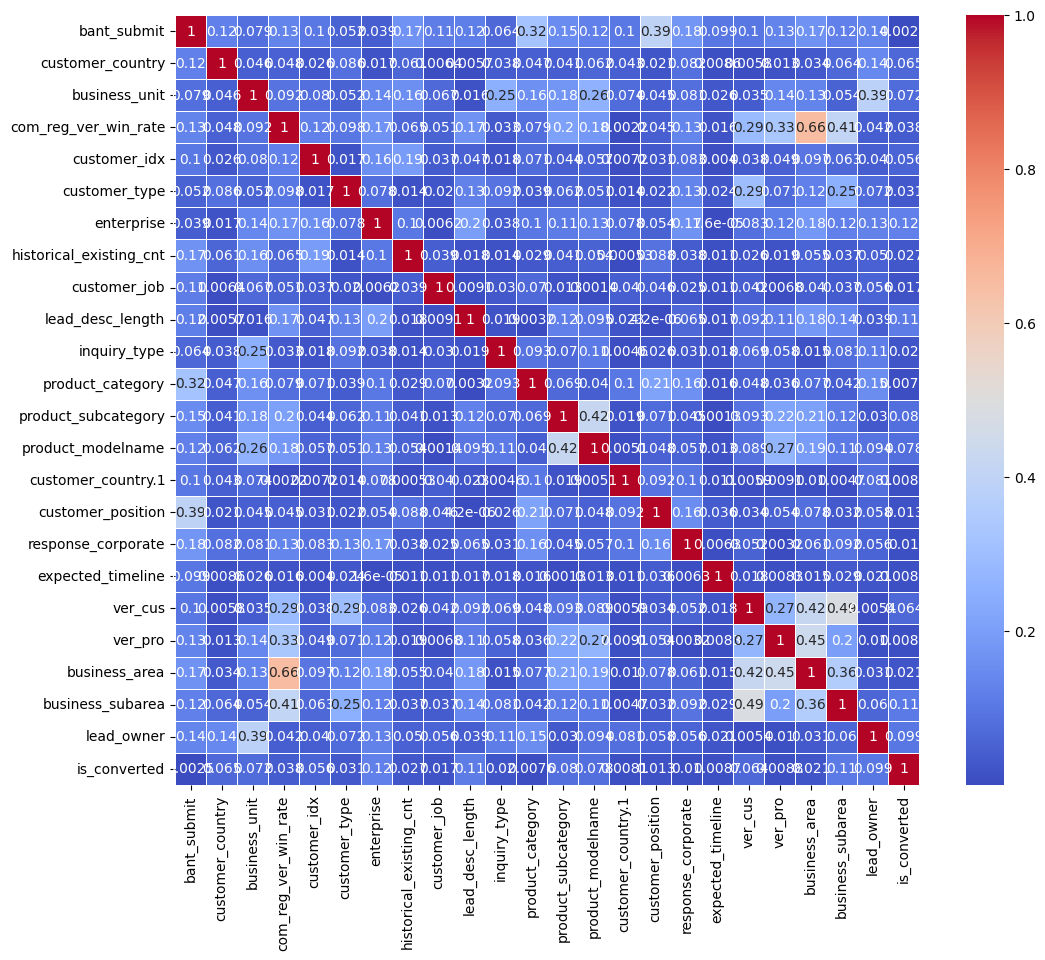

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df_train.corr()


# 상관관계 매트릭스를 히트맵으로 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(abs(correlation_matrix), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()
#df_train.drop(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'customer_country.1'],axis=1,inplace=True)
#df_test.drop(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'customer_country.1'],axis=1,inplace=True)

### 2-2. 학습, 검증 데이터 분리

#### tomek links

In [ ]:
'''
# 수치형 컬럼의 NaN 값을 평균으로 대체
# 수치형 컬럼을 식별합니다.
numeric_columns = list(set(df_train.columns) - set(label_columns))

for col in numeric_columns:
    if df_train[col].isnull().any():
        df_train[col].fillna(df_train[col].mean(), inplace=True)
categorical_features_indices=[]
# 범주형 컬럼의 NaN 값을 가장 빈번한 값으로 대체
for col in label_columns:
    if df_train[col].isnull().any():
        df_train[col].fillna(df_train[col].mode()[0], inplace=True)
    categorical_features_indices=df_train.columns.get_loc(col)
    
'''

'\n# 수치형 컬럼의 NaN 값을 평균으로 대체\n# 수치형 컬럼을 식별합니다.\nnumeric_columns = list(set(df_train.columns) - set(label_columns))\n\nfor col in numeric_columns:\n    if df_train[col].isnull().any():\n        df_train[col].fillna(df_train[col].mean(), inplace=True)\ncategorical_features_indices=[]\n# 범주형 컬럼의 NaN 값을 가장 빈번한 값으로 대체\nfor col in label_columns:\n    if df_train[col].isnull().any():\n        df_train[col].fillna(df_train[col].mode()[0], inplace=True)\n    categorical_features_indices=df_train.columns.get_loc(col)\n    \n'

In [ ]:

# TRUE와 FALSE 개수 세기
true_count = df_train['is_converted'].sum()
false_count = len(df_train) - true_count

# 두 개수 중 작은 값으로 데이터를 분할
min_count = min(true_count, false_count)

# TRUE와 FALSE 개수를 맞추어 데이터를 분할
true_data = df_train[df_train['is_converted'] == True].sample(n=min_count, random_state=400)
false_data = df_train[df_train['is_converted'] == False].sample(n=min_count, random_state=400)

# 데이터를 결합
df_balanced = pd.concat([true_data, false_data])

# val set을 먼저 구성
val_size = int(len(df_balanced) * 0.2)  # 전체 데이터의 20%를 val set으로 사용
val_set = df_balanced.sample(n=val_size, random_state=400)

# val_set을 x_val과 y_val로 분리
x_val = val_set.drop("is_converted", axis=1)
y_val = val_set["is_converted"]

# train set 구성 (비율을 맞추기 전의 데이터 사용)
train_set = df_train.drop(val_set.index)

# train set과 val set 구성 확인
print("Train set:")
print(train_set['is_converted'].value_counts())
print("Validation set:")
print(val_set['is_converted'].value_counts())


Train set:
False    53483
True      3876
Name: is_converted, dtype: int64
Validation set:
True     974
False    966
Name: is_converted, dtype: int64


In [ ]:

from imblearn.under_sampling import TomekLinks, RandomUnderSampler
import pandas as pd


# Tomek Link를 적용하여 데이터 보정
tl = TomekLinks()
x_train_resampled, y_train_resampled = tl.fit_resample(train_set.drop("is_converted", axis=1), train_set["is_converted"])

# 클래스 비율 맞추기
rus = RandomUnderSampler(sampling_strategy={0: int(y_train_resampled.sum() * 1), 1: y_train_resampled.sum()}, random_state=42)
x_train, y_train = rus.fit_resample(x_train_resampled, y_train_resampled)

# 결과 확인
print("Train set after Tomek Links and balancing classes:")
print(pd.Series(y_train).value_counts())


Train set after Tomek Links and balancing classes:
False    3876
True     3876
Name: is_converted, dtype: int64


In [ ]:
# x_train, x_val, y_train, y_val = train_test_split(
#     df_train.drop("is_converted", axis=1),
#     df_train["is_converted"],
#     test_size=0.2,
#     shuffle=True,
#     random_state=400,
# )

## 3. 모델 학습

### 모델 정의 

In [ ]:
#model = DecisionTreeClassifier()
#model = DecisionTreeClassifier(max_depth=12, min_samples_split=3, min_samples_leaf=5)
#model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2)
true_count = sum(df_train['is_converted'] == True)
false_count = sum(df_train['is_converted'] == False)
scale_pos_weight = false_count / true_count
#scale_pos_weight=scale_pos_weight*0.5
# XGBoost 모델 초기화
model = XGBClassifier()


model_param_grid = {
    'n_estimators': [100, 150,200],
    'learning_rate': [0.1, 0.15, 0.2, 0.3],
    'max_depth': [6, 8, 10, 12]
}

model_grid=GridSearchCV(model, param_grid = model_param_grid, scoring="accuracy", n_jobs=-1, verbose = 1)
model_grid.fit(x_train, y_train)
model = model_grid.best_estimator_
model.fit(x_train, y_train) 





Fitting 5 folds for each of 48 candidates, totalling 240 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 모델 학습

In [ ]:
model.fit(x_train.fillna(-1), y_train) # -1 로 바꿔뒀음

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 모델 성능 보기

In [ ]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, pred)
    TP = confusion[1][1]
    FP = confusion[0][1]
    TN = confusion[0][0]
    FN = confusion[1][0]
    print(f"True Positive(TP): {TP}, False Positive(FP): {FP}, True Negative(TN): {TN}, False Negative(FN): {FN}")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [ ]:
#pred = model.predict(x_val_selected_features.fillna(0))
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)
print(type(model))
#print("트리의 최대 깊이:", model.tree_.max_depth)


True Positive(TP): 926, False Positive(FP): 69, True Negative(TN): 897, False Negative(FN): 48
오차행렬:
 [[897  69]
 [ 48 926]]

정확도: 0.9397
정밀도: 0.9307
재현율: 0.9507
F1: 0.9406
<class 'xgboost.sklearn.XGBClassifier'>


## 4. 제출하기

### 테스트 데이터 예측

In [ ]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [ ]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

1696

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

#in vscode gitignore issue

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**